# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 21.09.2020

Мягкий дедлайн: 02:59MSK 05.10.2020

Жесткий дедлайн: 23:59MSK 08.10.2020

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 10 + 1.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

### *`Все комментарии написаны курсивом`*

In [ ]:
!pip install folium

In [2]:
import folium
m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)
m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
data = pd.read_csv('train.csv')

In [5]:
data.sample(2)

id  vendor_id      pickup_datetime     dropoff_datetime  \
526792  id1328633          2  2016-01-01 12:51:19  2016-01-01 12:58:06   
782892  id3136681          1  2016-05-01 02:34:00  2016-05-01 02:44:36   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
526792                1        -73.979736        40.735264         -73.993530   
782892                1        -74.000542        40.732239         -73.986916   

        dropoff_latitude store_and_fwd_flag  trip_duration  
526792         40.730644                  N            407  
782892         40.761162                  N            636

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [6]:
import datetime as dt
data.drop(columns=['dropoff_datetime'], inplace=True)    # delete dropoff_datetime
data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)    # transform pickup_datetime into datetime object

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

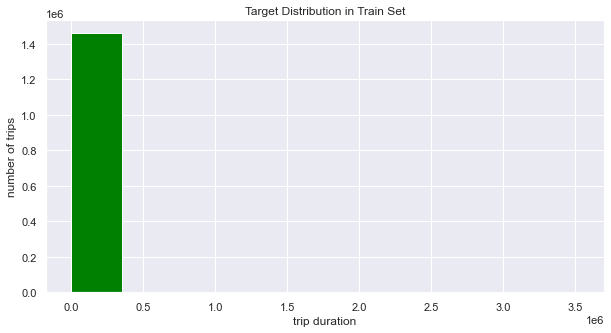

In [7]:
plt.figure(figsize=(10,5))
plt.hist(data.trip_duration, align='mid', bins=10, color='green')
plt.xlabel('trip duration', size=12)
plt.ylabel('number of trips', size=12)
plt.title('Target Distribution in Train Set', size=12)
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

*В выборке есть выбросы, из-за которых гистограмма получается неинформативной.*

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

*RMSLE менее чувствительна к выбросам, чем RMSE, а также при использовании RMSLE за переоценку даётся меньший штраф, чем за недооценку (в отличии от RMSE, который за переоценку и недооценку на одно и то же значение даёт одинаковый штраф), что важно при прогнозе продолжительности поездки на такси.*

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: Подставим в выражения $a(x_i) = \exp(\hat{a}(x_i)) - 1$ и $\hat{y}_i = \log{(y_i + 1)}$:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(\exp(\hat{a}(x_i)))}\big)^2} =$$ $$=\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \hat{a}(x_i)\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2} = \sqrt{\text{MSE}(X, \hat{y}, \hat{a})}$$
Таким образом, из равенства $\text{RMSLE}(X, y, a) = \sqrt{\text{MSE}(X, \hat{y}, \hat{a})}$ получаем, что нахождение минимума в одном случае эквивалентно нахождению минимума в другом.


Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [8]:
data.loc[:,'log_trip_duration'] = np.log1p(data.trip_duration)

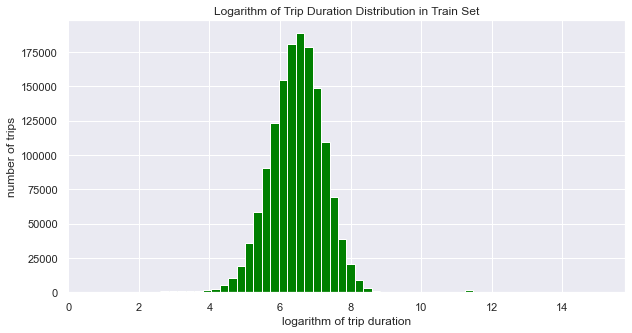

In [9]:
plt.figure(figsize=(10,5))
plt.hist(data.log_trip_duration, bins=60, align='mid', color='green')
plt.xlabel('logarithm of trip duration', size=12)
plt.ylabel('number of trips',size=12)
plt.title('Logarithm of Trip Duration Distribution in Train Set',size=12)
plt.show()

In [10]:
data.drop(columns=['trip_duration'], inplace=True)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

**Примечание:** *Покажем, что $\bar{y} = \frac{1}{\ell}\sum\limits_{i=1}^{\ell}y_i$ является наилучшим константным предсказанием в MSE:*

$$\text{MSE} = \sum_{i=1}^{\ell}\big(y_i - \alpha \big)^2 \rightarrow \min$$
$$\big(\text{MSE}\big)^{\prime}_{\alpha} = \frac{1}{\ell}\sum_{i=1}^{\ell}2(\alpha - y_i) = 0 \iff \alpha = \bar{y}$$

In [11]:
from sklearn.metrics import mean_squared_error
target = data.log_trip_duration
best_constant = target.mean()
const_mse = mean_squared_error(target, best_constant * np.ones(target.shape), squared=True)
print('MSE for best constant prediction: %.4f' %const_mse)

MSE for best constant prediction: 0.6332


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [12]:
df = data.copy(deep=True)    # for graphs

In [13]:
df.loc[:, 'pickup_date'] = df['pickup_datetime'].dt.date

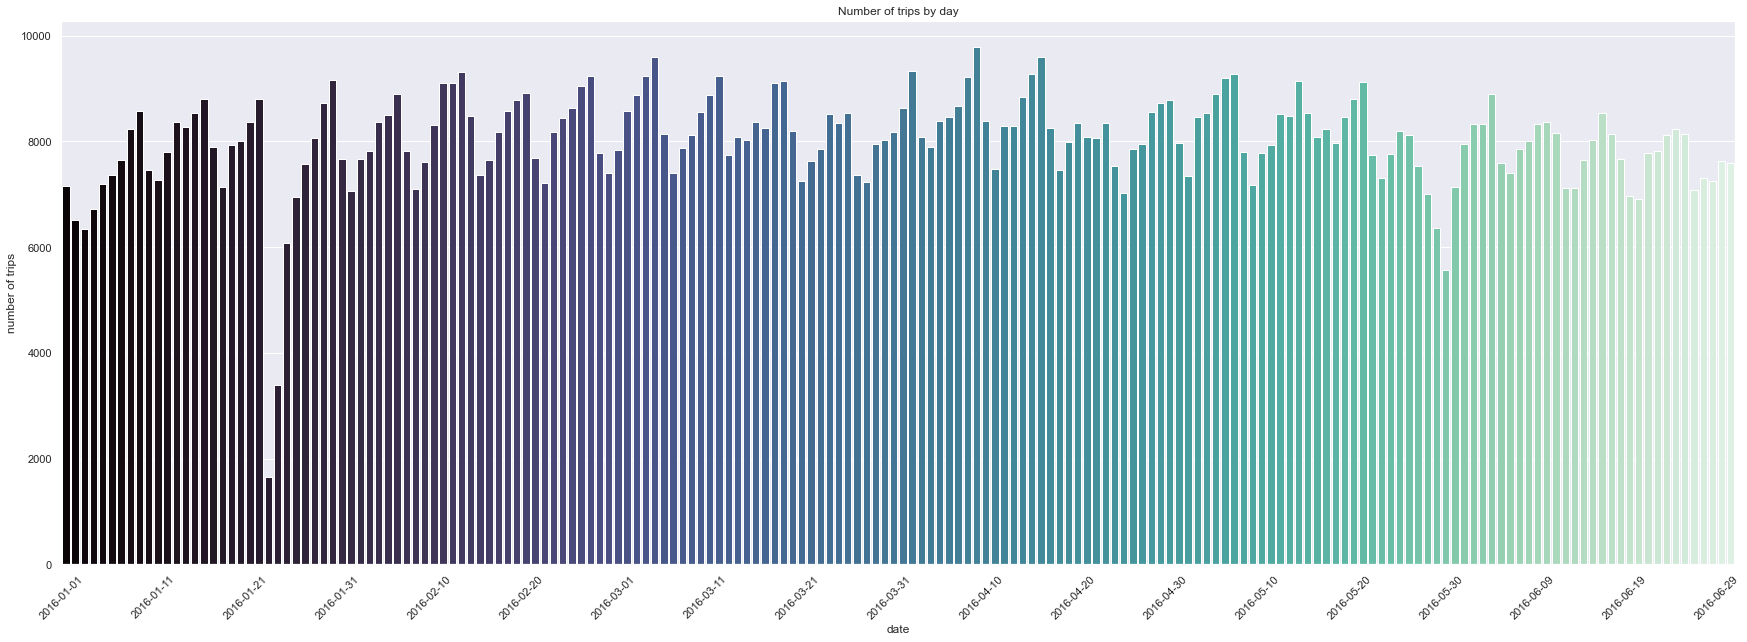

In [14]:
plt.figure(figsize=(30,10))

ax = sns.countplot(x='pickup_date',data=df.sort_values(['pickup_date']), palette='mako')

start, end = ax.get_xlim()
stepsize=10
date_ticks = df.pickup_date.unique()
date_ticks.sort()
plt.xticks(ticks=np.arange(start, end, stepsize), labels=date_ticks[::stepsize])
plt.xticks(rotation=45)

plt.title('Number of trips by day', size=12)
plt.xlabel('date', size=12)
plt.ylabel('number of trips', size=12)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

In [15]:
date_sorted = df.groupby('pickup_date').count().sort_values(['vendor_id'])[['vendor_id']].reset_index()
date_sorted.rename(columns={'vendor_id':'count'}, inplace=True)
date_sorted.head(5)

pickup_date  count
0  2016-01-23   1648
1  2016-01-24   3383
2  2016-05-30   5570
3  2016-01-25   6084
4  2016-01-03   6353

`Jan 23-24 2016`: [NYC travel ban](https://www.usatoday.com/story/weather/2016/01/23/blizzard-continues-slam-east-coast/79217258/)

`May 30 2016`: [Memorial Day heavy traffic](https://www.boston.com/news/local-news/2016/05/27/heavy-traffic-memorial-day-weekend-getaway-boston)

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [16]:
df.loc[:,'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:,'pickup_weekday'] = df['pickup_datetime'].dt.day_name()
df.loc[:,'pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek

In [17]:
weekday_sort = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
count_by_weekday = df.groupby('pickup_weekday').count().reindex(weekday_sort)[['vendor_id']].reset_index()
count_by_weekday.rename(columns={'vendor_id':'count'},inplace=True)

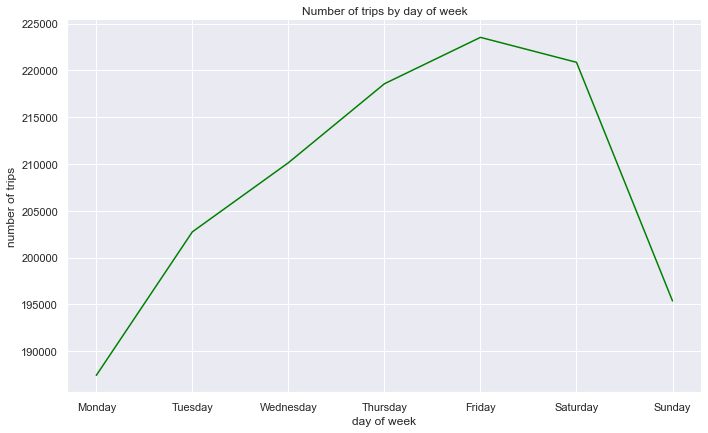

In [18]:
sns.relplot(data=count_by_weekday,x='pickup_weekday',y='count', height=6, aspect=10/6, color='green', kind='line', sort=False)
plt.xlabel('day of week', size=12)
plt.ylabel('number of trips', size=12)
plt.title('Number of trips by day of week', size=12)
plt.show()

In [19]:
count_by_hour = df.sort_values('pickup_hour').groupby('pickup_hour').count()[['vendor_id']].reset_index()
count_by_hour.rename(columns={'vendor_id':'count'},inplace=True)

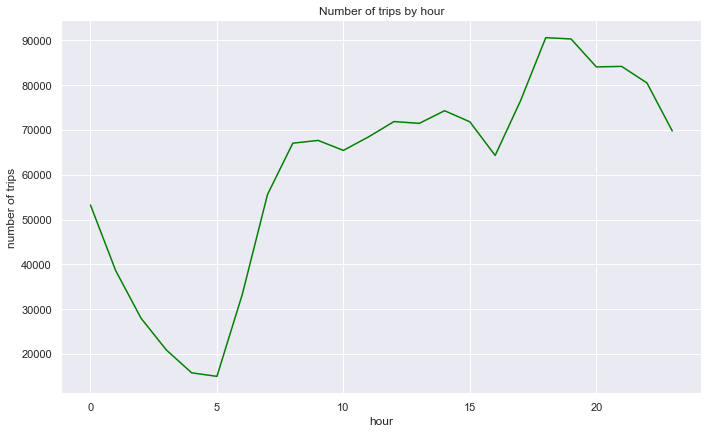

In [20]:
sns.relplot(data=count_by_hour,x='pickup_hour',y='count', height=6, aspect=10/6, color='green', kind='line')
plt.title('Number of trips by hour', size=12)
plt.xlabel('hour',size=12)
plt.ylabel('number of trips', size=12)
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [21]:
df.loc[:, 'pickup_month'] = df.pickup_datetime.dt.month

In [22]:
hour_month = df.groupby(['pickup_hour','pickup_month']).count()[['vendor_id']].reset_index()
hour_month.rename(columns={'vendor_id':'count'},inplace=True)
hour_month.sort_values(['pickup_hour','pickup_month'],inplace=True)

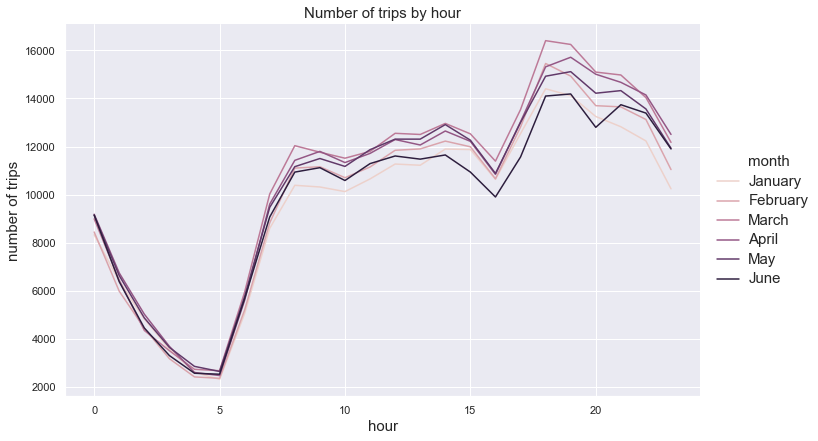

In [23]:
ax = sns.relplot(data=hour_month, x='pickup_hour',y='count',hue='pickup_month',kind='line',height=6, aspect=10/6, legend='full')

plt.xlabel('hour', size=15)
plt.ylabel('number of trips', size=15)

new_labels = ['January', 'February', 'March', 'April', 'May', 'June']
for t, l in zip(ax._legend.texts[1:], new_labels): t.set_text(l)
ax._legend.texts[0].set_text('month')
plt.setp(ax._legend.texts, fontsize=15)

plt.title('Number of trips by hour', size=15)
plt.show()

In [24]:
hour_weekday = df.groupby(['pickup_hour','pickup_weekday','pickup_day_of_week']).count()[['vendor_id']].reset_index()
hour_weekday.rename(columns={'vendor_id':'count'},inplace=True)
hour_weekday.sort_values(['pickup_hour','pickup_day_of_week'],inplace=True)
hour_weekday.drop(columns=['pickup_day_of_week'],inplace=True)

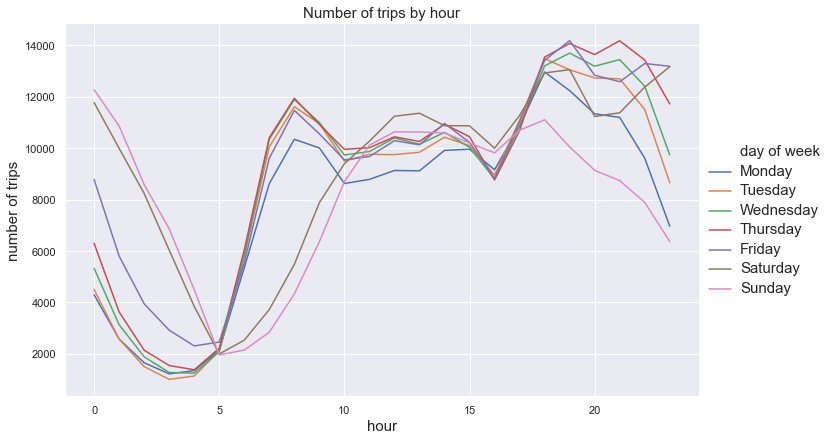

In [25]:
ax = sns.relplot(data=hour_weekday, x='pickup_hour', y='count', hue='pickup_weekday', kind='line', height=6, aspect=10/6)

plt.xlabel('hour',size=15)
plt.ylabel('number of trips', size=15)
ax._legend.texts[0].set_text('day of week')
plt.setp(ax._legend.texts, fontsize=15)

plt.title('Number of trips by hour', size=15)
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

- *Из первого графика видно, что количество поездок возрастает в течение недели и достигает пика в пятницу, в субботу количество немного снижается и сильно падает в воскресенье. (Вероятно, в пятницу и субботу люди встречаются с друзьями после работы, а в воскресенье уже отдыхают дома). В понедельник же количество поездок на такси меньше всего, возможно, большинство предпочитают ехать в общественном транспорте.*
- *Из графика зависимости от времени суток видно, что меньше всего поездок на такси в районе 4-5 часов утра, большинство в это время ещё спят. Количество поездок резко возрастает к 7-8, когда город начинает просыпаться. В течение дня количество поездок возрастает (однако есть некоторые провалы, например, в районе 16ти). В 18-19 наблюдается наибольшее количество поездок (люди возвращаются домой/едут отдыхать), после этого число поездок стабильно уменьшается.*
- *Изменение количества поездок в зависимости от времени суток для разных месяцев примерно одинаково. Можно выделить, что в январе как правило поездок меньше, относительно других месяцев, а больше всего в марте.*
- *Из последнего графика видно, что в выходные (в особенности в воскресенье), минимум числа поездок правее относительно будних (т.е. многие в то время, в которое в будни бы уже спали, в выходные ещё гуляют), а в остальное время суток количество поездок как правило меньше, чем в будние дни. В течение недели количество поездок увеличивается (видно из порядка расположения графиков) - в понедельник-вторник меньше всего, в четверг-пятницу больше всего.*

**Задание 4 (0.5 баллов)**. По *обучающей выборке* нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [26]:
weekday_sort = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mean_log_by_weekday = df.groupby('pickup_weekday')[['log_trip_duration']].mean().reindex(weekday_sort).reset_index()
mean_log_by_weekday.rename(columns={'log_trip_duration':'mean log trip duration'},inplace=True)

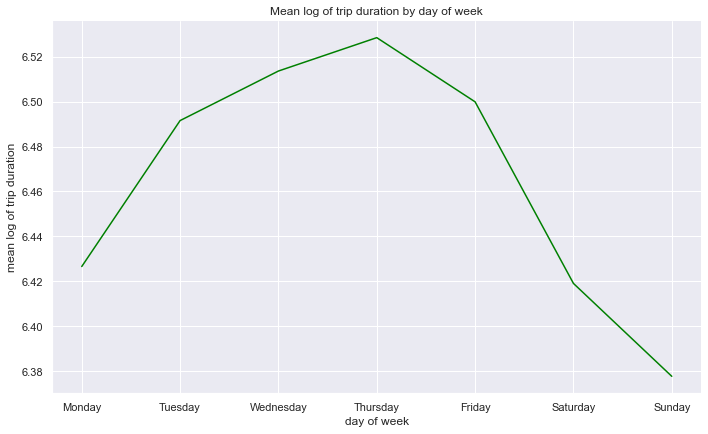

In [27]:
sns.relplot(data=mean_log_by_weekday, x='pickup_weekday',y='mean log trip duration',kind='line',height=6, aspect=10/6, sort=False, color='green')
plt.xlabel('day of week', size=12)
plt.ylabel('mean log of trip duration', size=12)
plt.title('Mean log of trip duration by day of week', size=12)
plt.show()

In [28]:
mean_log_by_hour = df.groupby('pickup_hour')[['log_trip_duration']].mean().reset_index()
mean_log_by_hour.rename(columns={'log_trip_duration':'mean log trip duration'},inplace=True)

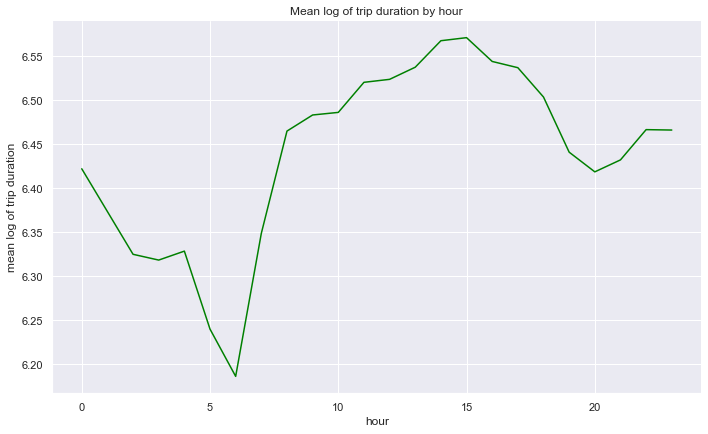

In [29]:
sns.relplot(data=mean_log_by_hour, x='pickup_hour',y='mean log trip duration',kind='line',height=6, aspect=10/6, color='green')
plt.xlabel('hour', size=12)
plt.ylabel('mean log of trip duration', size=12)
plt.title('Mean log of trip duration by hour', size=12)
plt.show()

In [30]:
mean_log_by_date = df.groupby('pickup_date')[['log_trip_duration']].mean().reset_index()
mean_log_by_date.rename(columns={'log_trip_duration':'mean log trip duration'},inplace=True)

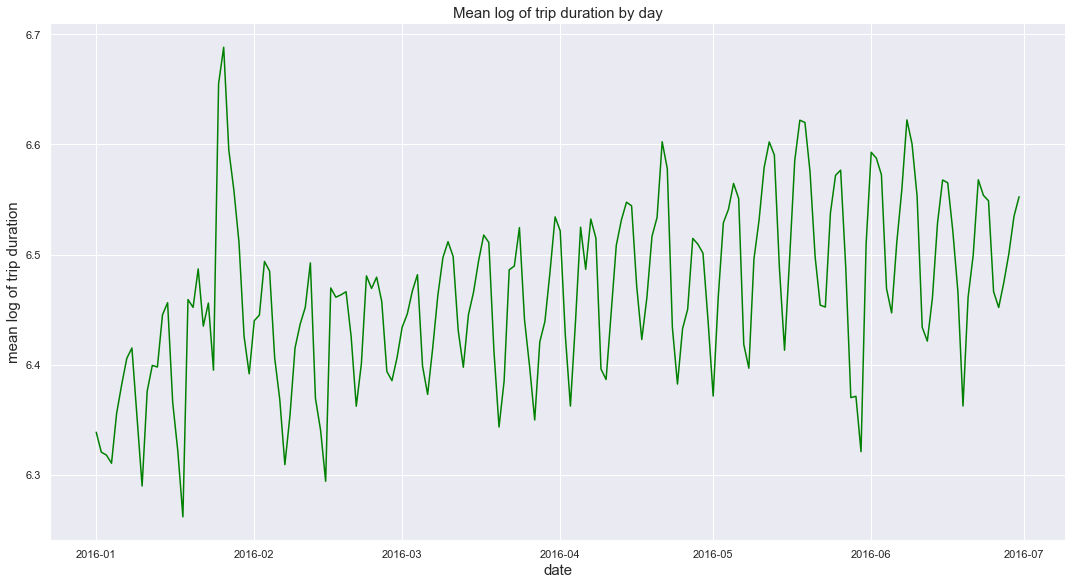

In [31]:
sns.relplot(data=mean_log_by_date, x='pickup_date',y='mean log trip duration',kind='line',height=8,aspect = 15/8, color='green')
plt.xlabel('date', size=15)
plt.ylabel('mean log of trip duration', size=15)
plt.title('Mean log of trip duration by day', size=15)
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

- *Графики зависимости таргета от дня недели и от часа в сутках похожи на аналогичные им графики для количества поездок (с наибольшим значением в четверг для первой пары графиков, с минимумом около 4-5 часов и возрастанию к 15-16 для второй пары). Возможно, это связано с тем, что самые оживлённые дни приходятся на середину недели (четверг-пятница), из-за чего и количество, и средняя продолжительность поездок возрастают.*

- *В аномальные периоды можем заметить, что среднее таргета делает видимый скачок (вверх в первый период - 23-24.01 и вниз во второй - 30.05). Объяснить это можно тем, что из-за погодных условий в январе было сильно затруднено транспортное движение, из-за чего продолжительность поездок сильно увеличена. 30ого мая же был государственный праздник, в который могли быть закрыты некоторые дороги. В Memorial Day также сильно затруднено передвижение по городу, из-за чего, возможно, поездки заказывались только на короткие расстояния / пассажиры попадали в пробку и выходили из такси.*

- *На графике зависимости среднего таргета от номер дня в году можем заметить, что, в целом, количество поездок растёт, а также то, что есть постоянные скачки (похоже на недельную периодичность).*

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [32]:
data.loc[:, 'weekday'] = data.pickup_datetime.dt.day_name() 
data.loc[:, 'month'] = data.pickup_datetime.dt.month
data.loc[:, 'hour'] = data.pickup_datetime.dt.hour
data.loc[:, 'yearday'] = data.pickup_datetime.dt.dayofyear

data.loc[:, 'is_first_anomaly'] = 1 * (data.pickup_datetime.dt.date == dt.date(2016, 1, 23)) | (data.pickup_datetime.dt.date == dt.date(2016, 1, 24))
data.loc[:, 'is_second_anomaly'] = 1 * (data.pickup_datetime.dt.date == dt.date(2016, 5, 30))

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

- *`Численные`: месяц*

- *`Бинарные`: является ли период аномальным*

- *`Категориальные`: день недели, час, номер дня в году*

*Признаки "день недели", "час" и "номер дня в году" не коррелируют линейно с целевой переменной (как было показано на графиках), поэтому отнесение их к численным привело бы к нереалистичной модели. Из последнего графика видно, что таргет растёт с увеличением значения месяца (визуально линейно), поэтому признак "месяц" отнесём к численным.*

**Задание 5 (0.75 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [33]:
from sklearn.model_selection import train_test_split

y = data['log_trip_duration']
X = data.drop(columns=['id', 'log_trip_duration'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [34]:
X_train_5 = X_train.loc[:,'weekday':'is_second_anomaly']
X_test_5 = X_test.loc[:,'weekday':'is_second_anomaly']

In [35]:
categorical_ft_5 = ['hour', 'weekday', 'yearday']
numerical_ft_5 = ['month']

In [36]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer_5 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_5),
    ('scaling', StandardScaler(), numerical_ft_5)
])

ridge_pipeline_5 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_5),
    ('regression', Ridge())
])

model_5 = ridge_pipeline_5.fit(X_train_5, y_train)
y_train_pred_5 = model_5.predict(X_train_5)
y_pred_5 = model_5.predict(X_test_5)

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred_5, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred_5, squared=True))

Test MSE = 0.6185
Train MSE = 0.6213


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [37]:
def show_circles_on_map(data, latitude_column, longitude_column, color, m=None):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """
    if m == None:
        location = (data[latitude_column].mean(), data[longitude_column].mean())
        m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=10,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [38]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [39]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

- `JFK Airport`
- `LaGuardia Airport`

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [40]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [41]:
# to prevent SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()

In [42]:
X_train.loc[:, 'haversine'] = haversine_array(X_train['pickup_latitude'].values, X_train['pickup_longitude'].values,
                                             X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values)
X_test.loc[:, 'haversine'] = haversine_array(X_test['pickup_latitude'].values, X_test['pickup_longitude'].values,
                                             X_test['dropoff_latitude'].values, X_test['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [43]:
X_train.loc[:, 'log_haversine'] = np.log1p(X_train.loc[:, 'haversine'])    # log1p to avoid problems with haversine == 0

X_test.loc[:, 'log_haversine'] = np.log1p(X_test.loc[:, 'haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [44]:
hav_corr_train = X_train[['haversine']].corrwith(y_train)
log_hav_corr_train = X_train[['log_haversine']].corrwith(y_train)
print('Correlation with log of trip duration:')
print('log of distance: %.4f' % log_hav_corr_train[0], '\tdistance: %.4f' %hav_corr_train[0])

Correlation with log of trip duration:
log of distance: 0.7498 	distance: 0.5655


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [45]:
X_train.loc[:, 'average_speed'] = X_train.haversine / np.expm1(y_train)
av_speed = X_train.average_speed

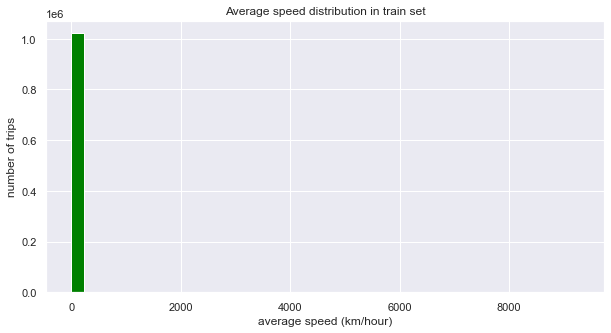

In [46]:
plt.figure(figsize=(10,5))
plt.hist(av_speed * 3600, bins=40, align='mid', color='green')
plt.xlabel('average speed (km/hour)', size=12)
plt.ylabel('number of trips', size=12)
plt.title('Average speed distribution in train set', size=12)
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [47]:
av_speed.describe()

count    1.021050e+06
mean     4.007667e-03
std      4.667758e-03
min      0.000000e+00
25%      2.533073e-03
50%      3.552988e-03
75%      4.956059e-03
max      2.576344e+00
Name: average_speed, dtype: float64

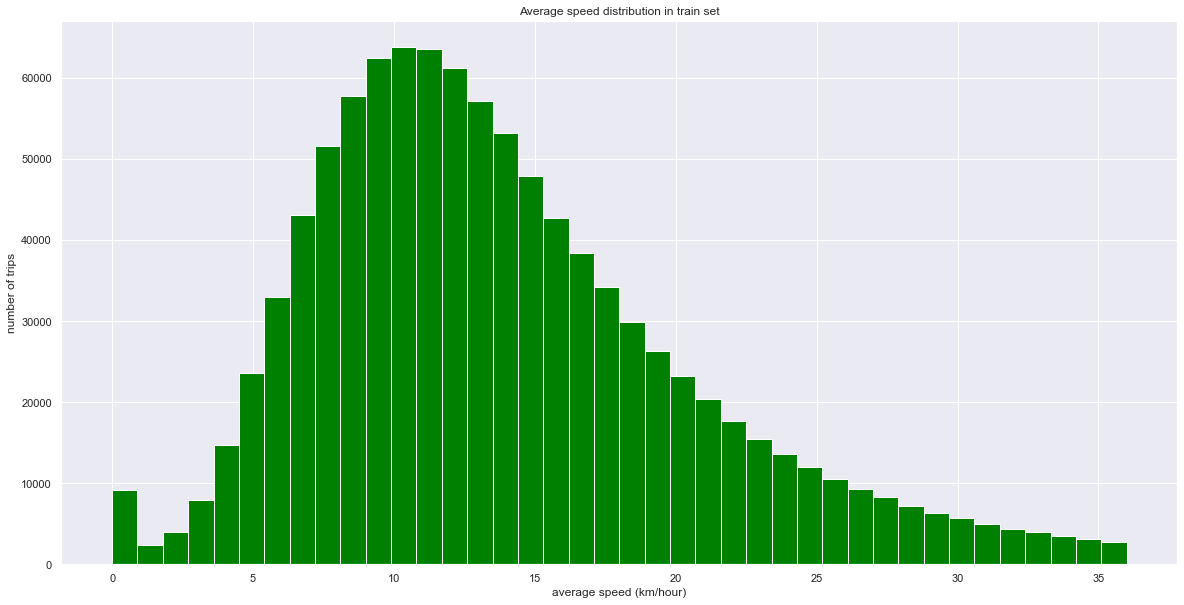

In [48]:
plt.figure(figsize=(20,10))
plt.hist(av_speed[av_speed <= 1e-2] * 3600, bins=40, align='mid', color='green')
plt.xlabel('average speed (km/hour)', size=12)
plt.ylabel('number of trips', size=12)
plt.title('Average speed distribution in train set', size=12)
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [49]:
dayname_sort = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
   
speed_medians = X_train.groupby(['weekday', 'hour'])[['average_speed']].mean()
speed_medians = speed_medians.unstack(level=0).droplevel(level=0, axis=1).reindex(dayname_sort, axis=1)
speed_medians *= 3600

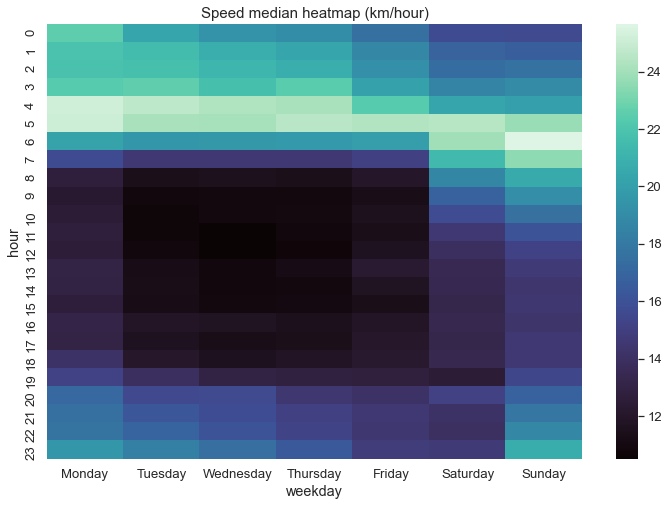

In [50]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1.2)
plt.title('Speed median heatmap (km/hour)', size=15)
sns.heatmap(speed_medians, cmap="mako")
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

In [51]:
X_train.drop(columns=['average_speed'], inplace=True)

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

*Скорость была посчитана через саму целевую переменную, вместе с haversine нужный ответ бы просто сохранился в выборке.*

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

- *Наименьшая скорость (10-12 км/час) наблюдается во вторник по пятницу с 8ми утра до 18ти вечера.*

- *Наибольшая скорость (24 км/час и больше) наблюдается с понедельника по пятницу в 4-5 утра, а также в выходные в 5-7 утра.*

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [52]:
heavy_traffic_weekday = [['Tuesday', 'Wednesday', 'Thursday', 'Friday']]
heavy_traffic_hours = [range(8, 19)]
light_traffic_weekday = [['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],['Saturday','Sunday']]
light_traffic_hours = [range(4, 6), range(5,8)]

In [53]:
X_train.loc[:,'is_in_light_traffic'] = False
X_train.loc[:,'is_in_heavy_traffic'] = False

for i in range(len(heavy_traffic_weekday)):
    X_train.loc[(X_train.weekday.isin(heavy_traffic_weekday[i])) & 
                (X_train.hour.isin(heavy_traffic_hours[i])), 
                'is_in_heavy_traffic'] = True
    
for i in range(len(light_traffic_weekday)):
    X_train.loc[(X_train.weekday.isin(light_traffic_weekday[i])) & 
                (X_train.hour.isin(light_traffic_hours[i])), 
                'is_in_light_traffic'] = True    

In [54]:
X_test.loc[:,'is_in_light_traffic'] = False
X_test.loc[:,'is_in_heavy_traffic'] = False

for i in range(len(heavy_traffic_weekday)):
    X_test.loc[(X_test.weekday.isin(heavy_traffic_weekday[i])) & 
                (X_test.hour.isin(heavy_traffic_hours[i])), 
                'is_in_heavy_traffic'] = True
    
for i in range(len(light_traffic_weekday)):
    X_test.loc[(X_test.weekday.isin(light_traffic_weekday[i])) & 
                (X_test.hour.isin(light_traffic_hours[i])), 
                'is_in_light_traffic'] = True    

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

`JFK airport coordinates:`
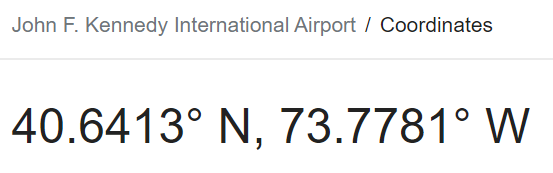

`LaGuardia airport coordinates:`
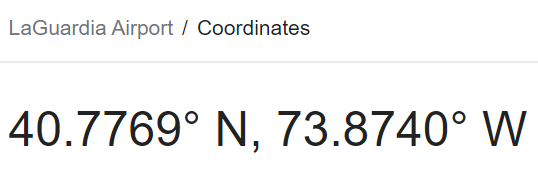

In [55]:
r = 0.01
X_train.loc[:, 'is_from_jfk'] = False
X_train.loc[:, 'is_to_jfk'] = False
X_train.loc[:, 'is_from_lga'] = False
X_train.loc[:, 'is_to_lga'] = False

X_test.loc[:, 'is_from_jfk'] = False
X_test.loc[:, 'is_to_jfk'] = False
X_test.loc[:, 'is_from_lga'] = False
X_test.loc[:, 'is_to_lga'] = False

In [56]:
jfk_coords = [40.645, -73.785]
from_jfk = np.hypot(X_train.pickup_latitude - jfk_coords[0], X_train.pickup_longitude - jfk_coords[1])
X_train.loc[from_jfk <= r, 'is_from_jfk'] = True
to_jfk = np.hypot(X_train.dropoff_latitude - jfk_coords[0], X_train.dropoff_longitude - jfk_coords[1])
X_train.loc[to_jfk <= r, 'is_to_jfk'] = True

from_jfk = np.hypot(X_test.pickup_latitude - jfk_coords[0], X_test.pickup_longitude - jfk_coords[1])
X_test.loc[from_jfk <= r, 'is_from_jfk'] = True
to_jfk = np.hypot(X_test.dropoff_latitude - jfk_coords[0], X_test.dropoff_longitude - jfk_coords[1])
X_test.loc[to_jfk <= r, 'is_to_jfk'] = True

In [57]:
lga_coords = [40.775, -73.87]
from_lga = np.hypot(X_train.pickup_latitude - lga_coords[0], X_train.pickup_longitude - lga_coords[1])
X_train.loc[from_lga <= r, 'is_from_lga'] = True
to_lga = np.hypot(X_train.dropoff_latitude - lga_coords[0], X_train.dropoff_longitude - lga_coords[1])
X_train.loc[to_lga <= r, 'is_to_lga'] = True

from_lga = np.hypot(X_test.pickup_latitude - lga_coords[0], X_test.pickup_longitude - lga_coords[1])
X_test.loc[from_lga <= r, 'is_from_lga'] = True
to_lga = np.hypot(X_test.dropoff_latitude - lga_coords[0], X_test.dropoff_longitude - lga_coords[1])
X_test.loc[to_lga <= r, 'is_to_lga'] = True

*Убедимся, что признаки выделены верно, отметив точки на карте:*

In [58]:
from_airport = show_circles_on_map(X_train[X_train.is_from_jfk == True].sample(1000), "pickup_latitude", "pickup_longitude", "blue")
show_circles_on_map(X_train[X_train.is_from_lga == True].sample(1000), "pickup_latitude", "pickup_longitude", "blue", from_airport)

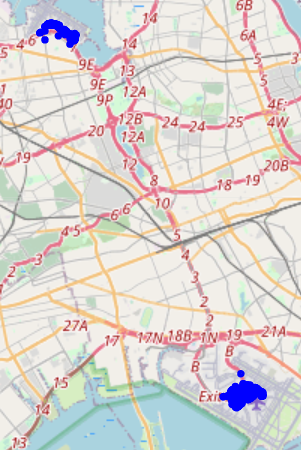

In [59]:
to_airport = show_circles_on_map(X_train[X_train.is_to_lga == True].sample(1000), "dropoff_latitude", "dropoff_longitude", "green")
show_circles_on_map(X_train[X_train.is_to_jfk == True].sample(1000), "dropoff_latitude", "dropoff_longitude", "green", to_airport)

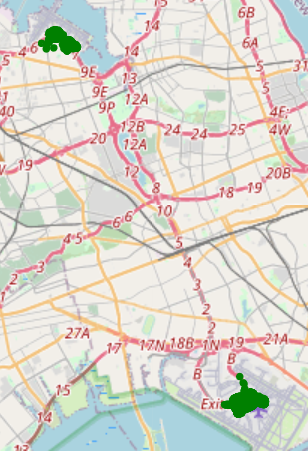

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

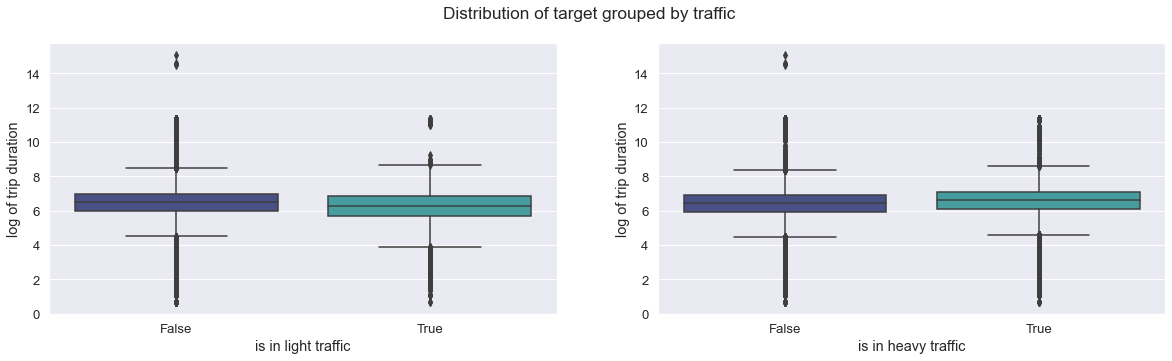

In [60]:
fig = plt.figure(figsize=(20,5))
fig.suptitle('Distribution of target grouped by traffic')
ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x='is_in_light_traffic', y='log_trip_duration', data=X_train.join(y_train), palette='mako')
ax1.set(ylabel='log of trip duration', xlabel='is in light traffic')
ax2 = fig.add_subplot(122)
ax2 = sns.boxplot(x='is_in_heavy_traffic', y='log_trip_duration', data=X_train.join(y_train), palette='mako')
ax2.set(ylabel='log of trip duration', xlabel='is in heavy traffic')
plt.show()

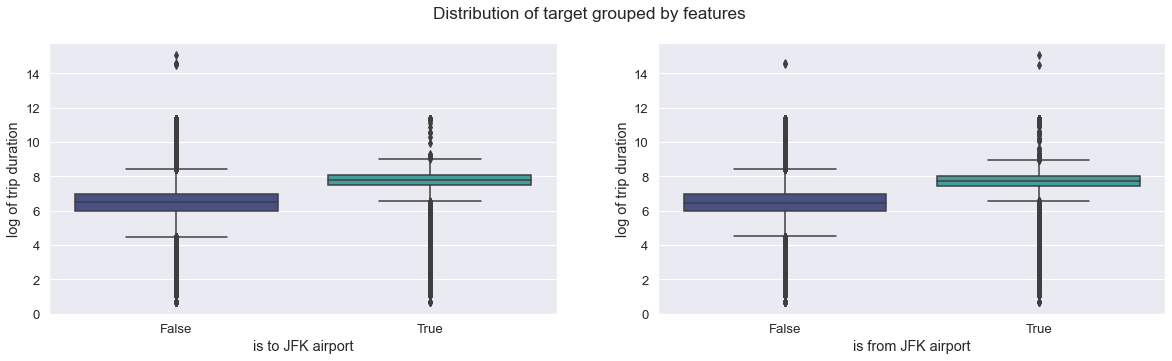

In [61]:
fig = plt.figure(figsize=(20,5))
fig.suptitle('Distribution of target grouped by features')
ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x='is_to_jfk', y='log_trip_duration', data=X_train.join(y_train), palette='mako')
ax1.set(ylabel='log of trip duration', xlabel='is to JFK airport')
ax2 = fig.add_subplot(122)
ax2 = sns.boxplot(x='is_from_jfk', y='log_trip_duration', data=X_train.join(y_train), palette='mako')
ax2.set(ylabel='log of trip duration', xlabel='is from JFK airport')
plt.show()

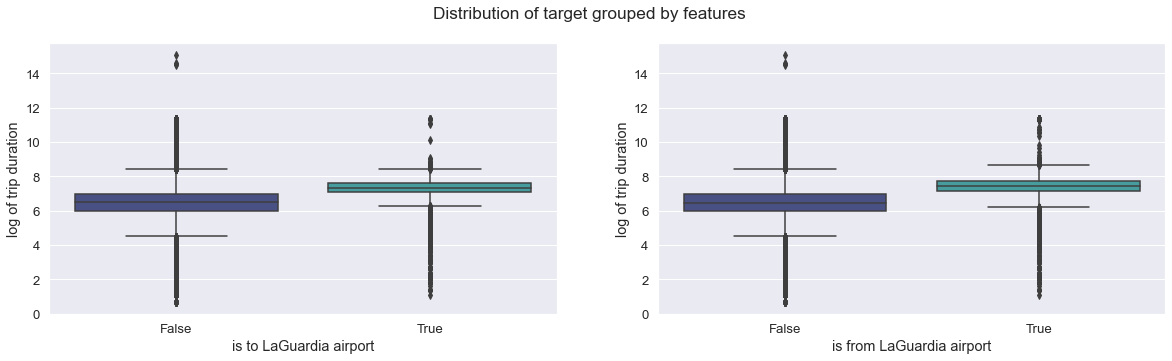

In [62]:
fig = plt.figure(figsize=(20,5))
fig.suptitle('Distribution of target grouped by features')
ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x='is_to_lga', y='log_trip_duration', data=X_train.join(y_train), palette='mako')
ax1.set(ylabel='log of trip duration', xlabel='is to LaGuardia airport')
ax2 = fig.add_subplot(122)
ax2 = sns.boxplot(x='is_from_lga', y='log_trip_duration', data=X_train.join(y_train), palette='mako')
ax2.set(ylabel='log of trip duration', xlabel='is from LaGuardia airport')
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

*Ящики (интеквартильные размахи) для признаков, показывающих, что поездка была из аэропорта или до него получились узкими, что означает, что у большинства объектов с значением True признака похожая продолжительность поездки (видно, что поездки в аэропорт/из него как правило дольше). А это значит, что эти признаки могут быть хорошими при прогнозе целевой переменной. Для признаков, отвечающих за передвижение в пробке (либо на свободных дорогах), оба ящика для разных значений получились одинаковыми и находящимися на одном уровне, что показывает, что этот признак не является хорошим для прогноза целевой переменной.*

*Приведём значения бинарных признаков к 0 и 1.*

In [63]:
binary_ft = ['is_first_anomaly', 'is_second_anomaly', 'is_in_light_traffic', 'is_in_heavy_traffic','is_from_jfk', 'is_to_jfk', 'is_from_lga', 'is_to_lga']

for col in binary_ft:
    X_train[col] = 1 * (X_train[col])
    X_test[col] = 1 * (X_test[col])

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    """
    breaks area into cells and determines for each point which cell it is located in
    """
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.cell_area = [None] * (rows * cols)    # list of coordinates for each cell
        
    def fit(self, X, y=None):
        area_left_corner = (40.810242, -74.010519)     # 
        area_right_corner = (40.711323, -73.938566)    # set explicitly
        
        for xx in range(self.rows):
            for yy in range(self.cols):
                left_corner = [0, 0]
                left_corner[0] = xx * (area_right_corner[0] - area_left_corner[0]) / self.rows + area_left_corner[0]    # latitude
                left_corner[1] = yy * (area_right_corner[1] - area_left_corner[1]) / self.cols + area_left_corner[1]    # longitude

                right_corner = [0, 0]
                right_corner[0] = (xx + 1) * (area_right_corner[0] - area_left_corner[0]) / self.rows + area_left_corner[0]
                right_corner[1] = (yy + 1) * (area_right_corner[1] - area_left_corner[1]) / self.cols + area_left_corner[1]
                
                self.cell_area[xx * self.cols + yy] = (left_corner, right_corner)

        return self
    
    def is_in_cell(self, lat, lng, left_corner, right_corner):
        return (lat <= left_corner[0]) & (lat >= right_corner[0]) & (lng >= left_corner[1]) & (lng <= right_corner[1])
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy.loc[:,'pickup_cell'] = -1
        X_copy.loc[:,'dropoff_cell'] = -1
        
        for idx in range(len(self.cell_area)):
            xx = idx / self.cols
            yy = idx % self.cols
            
            pickup_cell_rows = self.is_in_cell(X_copy.pickup_latitude, X_copy.pickup_longitude, 
                                          self.cell_area[idx][0], self.cell_area[idx][1])
            X_copy.loc[pickup_cell_rows, 'pickup_cell'] = idx
            
            dropoff_cell_rows = self.is_in_cell(X_copy.dropoff_latitude, X_copy.dropoff_longitude, 
                                           self.cell_area[idx][0], self.cell_area[idx][1])
            X_copy.loc[dropoff_cell_rows, 'dropoff_cell'] = idx
        X_copy.drop(columns=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'], inplace=True)
        return X_copy

*Выберем параметры для трансформера (количество строк и столбцов, на которые поделим прямоугольник):*

In [65]:
# choose best rows and cols values (in range from 2 to 6)

best_mse = 100

for rows in range(2, 7):
    for cols in range(2, 7):
        mapgrid = MapGridTransformer(rows, cols)
        pipeline = Pipeline(steps=[
           ('map_grid', mapgrid),
           ('ohe', OneHotEncoder(handle_unknown="ignore")),
           ('regression', Ridge())
        ])
        XX = X_train.loc[:,'pickup_longitude':'dropoff_latitude']
        model = pipeline.fit(XX, y_train)
        y_train_pred = model.predict(XX)

        mse =  mean_squared_error(y_train, y_train_pred, squared=True)
        if mse < best_mse:
            print("rows:", rows, "cols:", cols, "Train MSE = %.4f" % mse)
            best_mse = mse
            best_params = (rows, cols)

rows: 2 cols: 2 Train MSE = 0.5740
rows: 2 cols: 3 Train MSE = 0.5734
rows: 2 cols: 4 Train MSE = 0.5726
rows: 2 cols: 5 Train MSE = 0.5723
rows: 2 cols: 6 Train MSE = 0.5721
rows: 3 cols: 2 Train MSE = 0.5718
rows: 3 cols: 3 Train MSE = 0.5713
rows: 3 cols: 4 Train MSE = 0.5713
rows: 3 cols: 5 Train MSE = 0.5695
rows: 5 cols: 2 Train MSE = 0.5692
rows: 5 cols: 3 Train MSE = 0.5688
rows: 5 cols: 4 Train MSE = 0.5683
rows: 5 cols: 5 Train MSE = 0.5669
rows: 6 cols: 5 Train MSE = 0.5658


In [66]:
print('best parameters:', best_params[0], best_params[1], '\t MSE:%.4f' % best_mse)

best parameters: 6 5 	 MSE:0.5658


**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [67]:
X_train_10 = X_train.drop(columns=['pickup_datetime', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'haversine'])
X_test_10 = X_test.drop(columns=['pickup_datetime', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'haversine'])

In [68]:
grid_ft = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude']

In [69]:
categorical_ft_10 = categorical_ft_5
numerical_ft_10 = numerical_ft_5 + ['log_haversine']

In [70]:
mg_ohe = Pipeline(steps=[
    ('mapgrid', MapGridTransformer(best_params[0], best_params[1])),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

column_transformer_10 = ColumnTransformer([
    ('mapgrid', mg_ohe, grid_ft),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_10),
    ('scaling', StandardScaler(), numerical_ft_10)
])

ridge_pipeline = Pipeline(steps=[
    ('mg_ohe_sclr', column_transformer_10),
    ('regression', Ridge())
])

model_10 = ridge_pipeline.fit(X_train_10, y_train)
y_train_pred_10 = model_10.predict(X_train_10)
y_pred_10 = model_10.predict(X_test_10)

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred_10, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred_10, squared=True))

Test MSE = 0.2296
Train MSE = 0.2308


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

*`vendor_id` - номер компании может быть полезен, т.к. разные компании могут предлагать услуги разного качества, так, например, люди могут больше заказывать длительные поездки у более престижной компании*

*`passenger_count` - большие компании могут заказывать более длительные поездки (разделив большую сумму на группу), тогда как один человек вероятно предпочтёт поехать на общественном транспорте (вместо больших затрат на поездку)*

*`store_and_fwd_flag`- флаг, возможно, чаще всего будет устанавливаться только при коротких поездках - когда таксист может принять за короткое время несколько поездок и через какое-то время отправить данные*

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [71]:
print('Number of unique values in vendor_id:', data.vendor_id.nunique())
print('Number of unique values in passenger_count:', data.passenger_count.nunique())
print('Number of unique values in store_and_fwd_flag:', data.store_and_fwd_flag.nunique())

Number of unique values in vendor_id: 2
Number of unique values in passenger_count: 10
Number of unique values in store_and_fwd_flag: 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

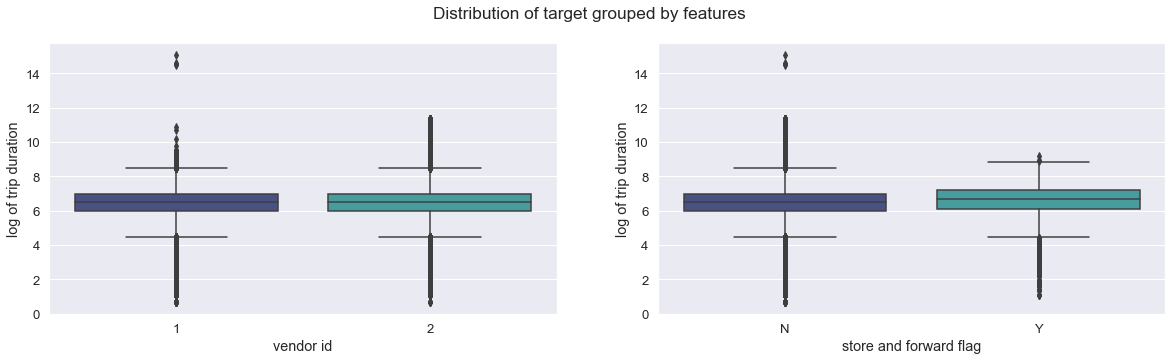

In [72]:
fig = plt.figure(figsize=(20,5))
fig.suptitle('Distribution of target grouped by features')
ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(x='vendor_id', y='log_trip_duration', data=X_train.join(y_train), palette='mako')
ax1.set(ylabel='log of trip duration', xlabel='vendor id')
ax2 = fig.add_subplot(122)
ax2 = sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', data=X_train.join(y_train), palette='mako')
ax2.set(ylabel='log of trip duration', xlabel='store and forward flag')
plt.show()

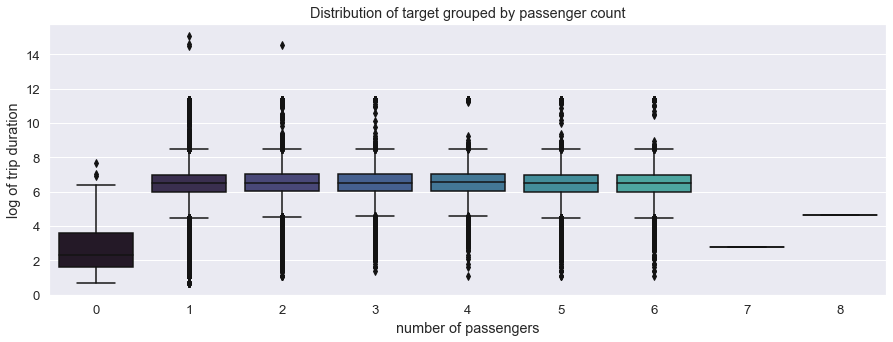

In [73]:
plt.figure(figsize=(15,5))
plt.title('Distribution of target grouped by passenger count')
ax = sns.boxplot(x='passenger_count', y='log_trip_duration', data=X_train.join(y_train), palette='mako')
ax.set(ylabel='log of trip duration', xlabel='number of passengers')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [74]:
print('vendor_id values:', X_train.vendor_id.unique())

vendor_id values: [2 1]


In [75]:
X_train.loc[:, 'vendor_id'] -= 1
X_test.loc[:, 'vendor_id'] -= 1
X_train.loc[:, 'store_and_fwd_flag'] = 1 * (X_train.store_and_fwd_flag == 'Y')
X_test.loc[:, 'store_and_fwd_flag'] = 1 * (X_test.store_and_fwd_flag == 'Y')

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

*Для всех признаков видно, что ящики для разных значений одного признака примерно одинаковы и находятся на одном уровне, что означает, что нельзя увидеть разницу целевой переменной для разных значений. Поэтому признаки вряд ли будут сильными. (В графике распределения по числу пассажиров (не считая выбросы в значениях 7 и 8 и аномальность в виде значения 0) также все ящики похожи).*

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [76]:
X_train_12 = X_train.drop(columns=['pickup_datetime','haversine'])
X_test_12 = X_test.drop(columns=['pickup_datetime','haversine'])

In [77]:
categorical_ft_12 = categorical_ft_10 + ['passenger_count', 'vendor_id']
numerical_ft_12 = numerical_ft_10

In [78]:
mg_ohe = Pipeline(steps=[
    ('mapgrid', MapGridTransformer(best_params[0], best_params[1])),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

column_transformer_12 = ColumnTransformer([
    ('mapgrid', mg_ohe, grid_ft),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_12),
    ('scaling', StandardScaler(), numerical_ft_12)
])

ridge_pipeline = Pipeline(steps=[
    ('mg_ohe_sclr', column_transformer_12),
    ('regression', Ridge())
])

model_12 = ridge_pipeline.fit(X_train_12, y_train)
y_train_pred_12 = model_12.predict(X_train_12)
y_pred_12 = model_12.predict(X_test_12)

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred_12, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred_12, squared=True))

Test MSE = 0.2293
Train MSE = 0.2305


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

*В задании 10 получились значения Test MSE = 0.2296, Train MSE = 0.2308, модель улучшилась примерно на 0.0003. Оставим выделенные в данном задании признаки.*

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким временем поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [79]:
### COMPILE ONCE ONLY ###
X_train_copy_13 = X_train.copy(deep=True)
X_test_copy_13 = X_test.copy(deep=True)
y_train_copy_13 = y_train.copy(deep=True)
y_test_copy_13 = y_test.copy(deep=True)
y_train_pred_copy_13 = y_train_pred_12.copy()

In [80]:
X_train = X_train_copy_13.copy(deep=True)
y_train = y_train_copy_13.copy(deep=True)
y_train_pred_12 = y_train_pred_copy_13.copy()

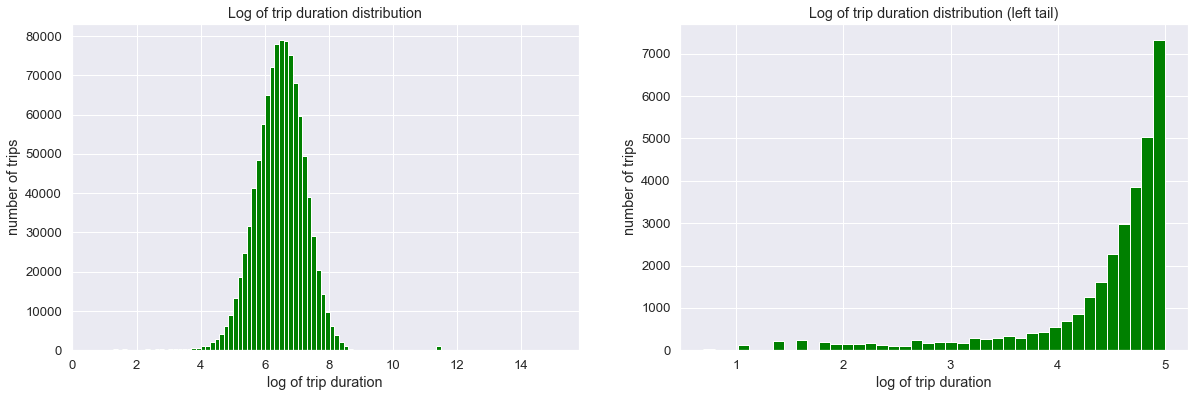

In [81]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1.hist(y_train, bins=100, align='mid', color='green')
ax1.set_title('Log of trip duration distribution')
ax1.set(xlabel='log of trip duration', ylabel='number of trips')
ax2 = plt.subplot(122)
ax2.set_title('Log of trip duration distribution (left tail)')
ax2.set(xlabel='log of trip duration', ylabel='number of trips')
ax2.hist(y_train[y_train < 5], bins=40, align='mid', color='green')
plt.show()

In [82]:
y_train_ri = y_train.reset_index(drop=True)    # to get positions (needed for deletion in y_train_pred)
target_anomaly_idx = y_train_ri[y_train_ri < 2.5].index    # trip duration = (e^2.5 - 1) ~ 12 seconds
keep_rows = list(set(range(X_train.shape[0])) - set(target_anomaly_idx))
X_train = X_train.iloc[keep_rows]
y_train = y_train.iloc[keep_rows]
y_train_pred_13 = pd.Series(y_train_pred_12).iloc[keep_rows]

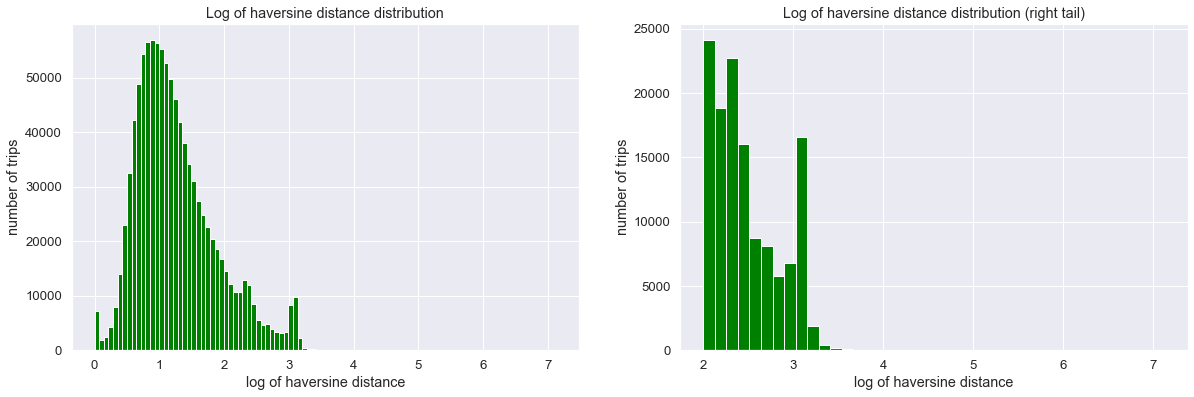

In [83]:
plt.figure(figsize=(20,6))
log_haversine = X_train.log_haversine
ax1 = plt.subplot(121)
ax1.hist(log_haversine, bins=100, align='mid', color='green')
ax1.set_title('Log of haversine distance distribution')
ax1.set(xlabel='log of haversine distance', ylabel='number of trips')
ax2 = plt.subplot(122)
ax2.set_title('Log of haversine distance distribution (right tail)')
ax2.set(xlabel='log of haversine distance', ylabel='number of trips')
ax2.hist(log_haversine[log_haversine > 2], bins=40, align='mid', color='green')
plt.show()

In [84]:
log_hav_ri = X_train.log_haversine.reset_index(drop=True)    # to get positions (needed for deletion in y_train_pred)
distance_anomaly_idx = log_hav_ri[log_hav_ri > 3.5].index
keep_rows = list(set(range(X_train.shape[0])) - set(distance_anomaly_idx))
X_train = X_train.iloc[keep_rows]
y_train = y_train.iloc[keep_rows]
y_train_pred_13 = y_train_pred_13.iloc[keep_rows]

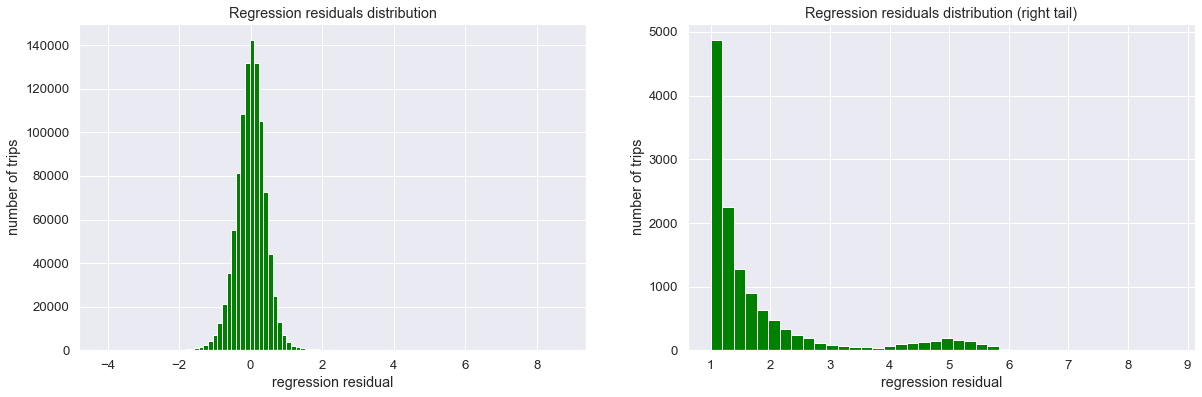

In [85]:
regr_rsdl = y_train.reset_index(drop=True) - y_train_pred_13.reset_index(drop=True)
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1.hist(regr_rsdl, bins=100, align='mid', color='green')
ax1.set_title('Regression residuals distribution')
ax1.set(xlabel='regression residual', ylabel='number of trips')
ax2 = plt.subplot(122)
ax2.set_title('Regression residuals distribution (right tail)')
ax2.set(xlabel='regression residual', ylabel='number of trips')
ax2.hist(regr_rsdl[regr_rsdl > 1], bins=40, align='mid', color='green')
plt.show()

In [86]:
regr_rsdl_anomaly_idx = regr_rsdl[regr_rsdl > 3].index
keep_rows = list(set(range(X_train.shape[0])) - set(regr_rsdl_anomaly_idx))
X_train = X_train.iloc[keep_rows]
y_train = y_train.iloc[keep_rows]

In [87]:
print('Size before anomaly data deletion:', X_train_copy_13.shape)
print('Size after anomaly data deletion:', X_train.shape)

Size before anomaly data deletion: (1021050, 22)
Size after anomaly data deletion: (1017574, 22)


Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

*Напишем трансформер, группирующий редкие категории (для созданных признаков `pickup_cell` и `dropoff_cell`):*

[Stackoverflow: filter rare categories](https://stackoverflow.com/questions/31303946/pandas-filter-dataframe-for-values-that-are-too-frequent-or-too-rare)

In [88]:
from collections import defaultdict
class CategoryGrouper (BaseEstimator, TransformerMixin):
    def __init__ (self, treshold):
        self.treshold = treshold
        self.grouped_values = defaultdict(list)
    
    def fit(self, X, y=None):
        X_copy = X.copy()
        for col in X_copy.columns:
            calc_col = X_copy[col].value_counts(normalize=True)
            self.grouped_values[col] = calc_col[calc_col < self.treshold].index
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X_copy.columns:
            X_copy.loc[X_copy[col].isin(self.grouped_values[col]), col] = self.grouped_values[col][0]    # set value of the most frequent (among rare)
        return X_copy

In [89]:
categorical_ft_13 = categorical_ft_12
categorical_ft_13

['hour', 'weekday', 'yearday', 'passenger_count', 'vendor_id']

[Stackoverflow: how to display dataframes side by side (ntg's solution)](https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side)

In [90]:
from IPython.display import display_html
def display_side_by_side(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [91]:
from IPython.display import display
df_list = []
for col in categorical_ft_13:
    values = X_train.groupby(col)[['pickup_datetime']].count().sort_values('pickup_datetime').head(5)
    values.rename(columns={'pickup_datetime':'count'}, inplace=True)
    df_list.append(values)

display_side_by_side(df_list)

count 
 
 
 hour 
 
 
 
 
 
 5 
 10327 
 
 
 4 
 11009 
 
 
 3 
 14494 
 
 
 2 
 19386 
 
 
 6 
 23046 
 
 
 
 
 
 
 count 
 
 
 weekday 
 
 
 
 
 
 Monday 
 130897 
 
 
 Sunday 
 136009 
 
 
 Tuesday 
 141286 
 
 
 Wednesday 
 146584 
 
 
 Thursday 
 152273 
 
 
 
 
 
 
 count 
 
 
 yearday 
 
 
 
 
 
 23 
 1157 
 
 
 24 
 2368 
 
 
 151 
 3857 
 
 
 25 
 4307 
 
 
 150 
 4377 
 
 
 
 
 
 
 count 
 
 
 passenger_count 
 
 
 
 
 
 7 
 1 
 
 
 8 
 1 
 
 
 0 
 18 
 
 
 4 
 19782 
 
 
 6 
 33705 
 
 
 
 
 
 
 count 
 
 
 vendor_id 
 
 
 
 
 
 0 
 474090 
 
 
 1 
 543484

*Как можно заметить, из всех признаков только в `passenger_count` есть редкие категории (0, 7 или 8 пассажиров). Заметим, что во всей выборке значение доходит до 9. Поэтому объединим категории в одну со значением 9.*

In [92]:
data.passenger_count.unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8], dtype=int64)

In [93]:
pass_cnt = X_train.passenger_count
X_train.loc[(pass_cnt == 7) | (pass_cnt == 8) | (pass_cnt == 0), 'passenger_count'] = 9
pass_cnt = X_test.passenger_count
X_test.loc[(pass_cnt == 7) | (pass_cnt == 8) | (pass_cnt == 0), 'passenger_count'] = 9

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [94]:
X_train_13 = X_train.drop(columns=['pickup_datetime', 'haversine'])
X_test_13 = X_test.drop(columns=['pickup_datetime', 'haversine'])

In [95]:
numerical_ft_13 = numerical_ft_12

In [96]:
print('Numerical features:', numerical_ft_13, '\nCategorical features:', categorical_ft_13)

Numerical features: ['month', 'log_haversine'] 
Categorical features: ['hour', 'weekday', 'yearday', 'passenger_count', 'vendor_id']


In [97]:
mg_ohe = Pipeline(steps=[
    ('mapgrid', MapGridTransformer(best_params[0], best_params[1])),
    ('cell_group', CategoryGrouper(0.001)),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

column_transformer_13 = ColumnTransformer([
    ('mapgrid', mg_ohe, grid_ft),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_13),
    ('scaling', StandardScaler(), numerical_ft_13)
])

ridge_pipeline = Pipeline(steps=[
    ('mg_ohe_sclr', column_transformer_13),
    ('regression', Ridge())
])

model_13 = ridge_pipeline.fit(X_train_13, y_train)
y_train_pred_13 = model_13.predict(X_train_13)
y_pred_13 = model_13.predict(X_test_13)

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred_13, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred_13, squared=True))

Test MSE = 0.2296
Train MSE = 0.1807


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте количество признаков до и после кодирования категориальных признаков.

In [98]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer_13.transform(X_train_13).shape)

Size before OneHot: (1017574, 22)
Size after OneHot: (1017574, 279)


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [99]:
from sklearn.linear_model import Lasso
mg_ohe = Pipeline(steps=[
    ('mapgrid', MapGridTransformer(best_params[0], best_params[1])),
    ('cell_group', CategoryGrouper(0.001)),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

column_transformer_14 = ColumnTransformer([
    ('mapgrid', mg_ohe, grid_ft),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_13),
    ('scaling', StandardScaler(), numerical_ft_13)
])

lasso_pipeline = Pipeline(steps=[
    ('mg_ohe_sclr', column_transformer_14),
    ('regression', Lasso())
])

model_14 = lasso_pipeline.fit(X_train_13, y_train)
y_train_pred_14 = model_14.predict(X_train_13)
y_pred_14 = model_14.predict(X_test_13)

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred_14, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred_14, squared=True))

Test MSE = 0.6309
Train MSE = 0.5679


*Для `Ridge` регрессии результат получился намного лучше (0.2296, 0.1807).*

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [100]:
X_train_14, X_val, y_train_14, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=10)

In [101]:
X_val_1 = X_val.drop(columns=['pickup_datetime', 'haversine'])
y_val_1 = y_val.drop(columns=['pickup_datetime', 'haversine'])
X_train_14_1 = X_train_14.drop(columns=['pickup_datetime', 'haversine'])

In [102]:
X_train_14_2 = X_train.drop(columns = ['pickup_datetime', 'haversine'])

##### Ridge:

In [103]:
ridge_alphas = np.logspace(-2, 3, 10)
best_ridge_alpha = None
best_ridge_mse = None
mse_ridge = list()

for alpha in ridge_alphas:
    mg_ohe = Pipeline(steps=[
        ('mapgrid', MapGridTransformer(best_params[0], best_params[1])),
        ('cell_group', CategoryGrouper(0.001)),
        ('ohe', OneHotEncoder(handle_unknown="ignore"))
    ])

    column_transformer_14_1 = ColumnTransformer([
        ('mapgrid', mg_ohe, grid_ft),
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_13),
        ('scaling', StandardScaler(), numerical_ft_13)
    ])

    ridge_pipeline = Pipeline(steps=[
        ('mg_ohe_sclr', column_transformer_14_1),
        ('regression', Ridge(alpha))
    ])

    model_14_1 = ridge_pipeline.fit(X_train_14_1, y_train_14)
    y_pred_val = model_14_1.predict(X_val_1)
    mse = mean_squared_error(y_val_1, y_pred_val, squared=True)
    mse_ridge.append(mse)
    if ((not best_ridge_mse) or (best_ridge_mse > mse)):
        best_ridge_mse = mse
        best_ridge_alpha = alpha

Best coefficient for Ridge: 0.4642 	MSE: 0.1809


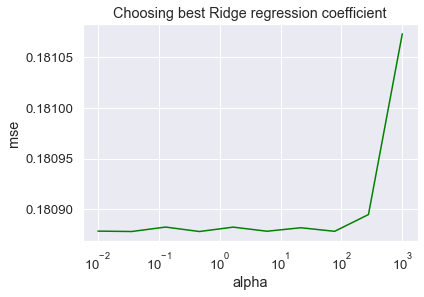

In [104]:
print('Best coefficient for Ridge: %.4f'% best_ridge_alpha, '\tMSE: %.4f' % best_ridge_mse)
plt.plot(ridge_alphas, mse_ridge, color='green')
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("mse")
plt.title('Choosing best Ridge regression coefficient')
plt.show()

In [105]:
mg_ohe = Pipeline(steps=[
    ('mapgrid', MapGridTransformer(best_params[0], best_params[1])),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

column_transformer_14_1 = ColumnTransformer([
    ('mapgrid', mg_ohe, grid_ft),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_13),
    ('scaling', StandardScaler(), numerical_ft_13)
])

ridge_pipeline = Pipeline(steps=[
    ('mg_ohe_sclr', column_transformer_14_1),
    ('regression', Ridge(best_ridge_alpha))
])

model_14_1 = ridge_pipeline.fit(X_train_14_2, y_train)
y_pred_14_1 = model_14_1.predict(X_test_13)

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred_14_1, squared=True))

Test MSE = 0.2296


##### Lasso:

In [106]:
lasso_alphas = np.logspace(-3, 2, 10)
best_lasso_alpha = None
best_lasso_mse = None
mse_lasso = list()
for alpha in lasso_alphas:
    mg_ohe = Pipeline(steps=[
        ('mapgrid', MapGridTransformer(best_params[0], best_params[1])),
        ('cell_group', CategoryGrouper(0.001)),
        ('ohe', OneHotEncoder(handle_unknown="ignore"))
    ])

    column_transformer_14_2 = ColumnTransformer([
        ('mapgrid', mg_ohe, grid_ft),
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_13),
        ('scaling', StandardScaler(), numerical_ft_13)
    ])

    lasso_pipeline = Pipeline(steps=[
        ('mg_ohe_sclr', column_transformer_14_2),
        ('regression', Lasso(alpha))
    ])

    model_14_2 = lasso_pipeline.fit(X_train_14_1, y_train_14)
    y_pred_val = model_14_2.predict(X_val_1)
    mse = mean_squared_error(y_val_1, y_pred_val, squared=True)
    mse_lasso.append(mse)
    if ((not best_lasso_mse) or (best_lasso_mse > mse)):
        best_lasso_mse = mse
        best_lasso_alpha = alpha

Best coefficient for Lasso: 0.001 	MSE: 0.1853


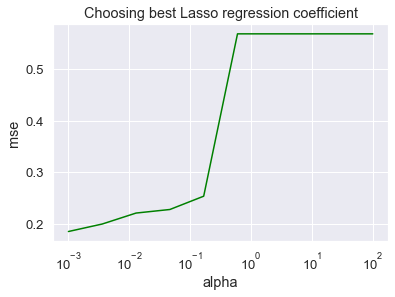

In [107]:
print('Best coefficient for Lasso:', best_lasso_alpha, '\tMSE: %.4f' % best_lasso_mse)
plt.plot(lasso_alphas, mse_lasso, color='green')
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("mse")
plt.title('Choosing best Lasso regression coefficient')
plt.show()

In [108]:
mg_ohe = Pipeline(steps=[
    ('mapgrid', MapGridTransformer(best_params[0], best_params[1])),
    ('cell_group', CategoryGrouper(0.001)),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

column_transformer_14_2 = ColumnTransformer([
    ('mapgrid', mg_ohe, grid_ft),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_13),
    ('scaling', StandardScaler(), numerical_ft_13)
])

lasso_pipeline = Pipeline(steps=[
    ('mg_ohe_sclr', column_transformer_14_2),
    ('regression', Lasso(best_lasso_alpha))
])

model_14_2 = lasso_pipeline.fit(X_train_14_2, y_train)
y_pred_14_2 = model_14_2.predict(X_test_13)

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred_14_2, squared=True))

Test MSE = 0.2340


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [109]:
lasso_zeros = []
for alpha in lasso_alphas:
    mg_ohe = Pipeline(steps=[
        ('mapgrid', MapGridTransformer(best_params[0], best_params[1])),
        ('cell_group', CategoryGrouper(0.001)),
        ('ohe', OneHotEncoder(handle_unknown="ignore"))
    ])

    column_transformer_14_2 = ColumnTransformer([
        ('mapgrid', mg_ohe, grid_ft),
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_13),
        ('scaling', StandardScaler(), numerical_ft_13)
    ])

    lasso_pipeline = Pipeline(steps=[
        ('mg_ohe_sclr', column_transformer_14_2),
        ('regression', Lasso(alpha))
    ])
    
    model_14_2 = lasso_pipeline.fit(X_train_14_2, y_train)

    lasso_zeros.append(np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0))

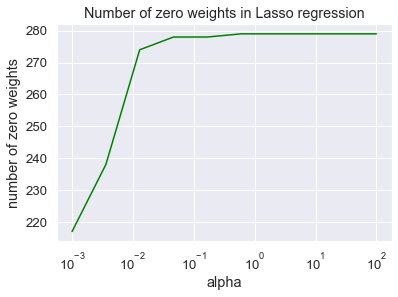

In [110]:
plt.plot(lasso_alphas, lasso_zeros, color='green')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('number of zero weights')
plt.title('Number of zero weights in Lasso regression')
plt.show()

In [111]:
print('Lasso zero weights:', lasso_zeros)

Lasso zero weights: [217, 238, 274, 278, 278, 279, 279, 279, 279, 279]


*Для `Lasso` регуляризации с коэффициентом $10^{-3}$ всего зануляется 217 из 279 признаков (более чем половина), ошибка равна 0.185. При таком же коэффициенте для `Ridge` регуляризации ошибка равна примерно 0.18, что показывает, что несильно отличается от `Lasso`. Для меньших коэффициентов (с занулением меньшего количества признаков) ошибки будут также схожи. При больших коэффициентах же для `Lasso` видно, что занулябтся почти все признаки, что приводит к значительному ухудшению модели.*

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

*Признак потенциально полезен, поскольку от маршрута напрямую зависит время поездки (а для частых маршрутов из одинаковых точек, вероятно, есть самые удобные маршруты).
Признак не может быть "вытащен" из информации, поскольку линейная модель не выводит взаимодействие признаков.*

*Напишем трансформер, выделяющий заданное число самых частых пар.*

In [112]:
class RoutePairTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, pair_num):
        self.pair_num = pair_num
        
    def fit (self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy.loc[:, 'count'] = 0
        routes = X_copy.groupby(['pickup_cell', 'dropoff_cell'])[['count']].count().head(self.pair_num).index
        
        X_copy.loc[:, 'route'] = -1
        for i in range(self.pair_num):
            pc = routes[i][0]
            dc = routes[i][1]
            X_copy.loc[(X_copy.pickup_cell == pc) & (X_copy.dropoff_cell == dc), 'route'] = i
        X_copy.drop(columns=['count'], inplace=True)
        
        return X_copy

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых данных и посчитайте качество на тестовой выборке

In [113]:
mg_ohe = Pipeline(steps=[
    ('mapgrid', MapGridTransformer(best_params[0], best_params[1])),
    ('cell_group', CategoryGrouper(0.001)),
    ('route', RoutePairTransformer(100)),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

column_transformer_15 = ColumnTransformer([
    ('mapgrid', mg_ohe, grid_ft),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_13),
    ('scaling', StandardScaler(), numerical_ft_13)
])

ridge_pipeline = Pipeline(steps=[
    ('mg_ohe_sclr', column_transformer_15),
    ('regression', Ridge(best_ridge_alpha))
])

model_15 = ridge_pipeline.fit(X_train_14_2, y_train)
y_train_pred_15 = model_15.predict(X_train_14_2)
y_pred_15 = model_15.predict(X_test_13)

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred_15, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred_15, squared=True))

Test MSE = 0.2284
Train MSE = 0.1792


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

*Поскольку большинство дорог Манхэттена расположены по сетке, расстояния многих поездок можно считать манхэттеновским (сумма абсолютных разниц координат) и поэтому этот признак может быть полезным*.

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [114]:
manhattan = folium.Map(location=(40.78, -73.97), tiles='Stamen Toner', zoom_start=12)
y_axis = [(40.827429,-73.935416),(40.729778,-74.005343)]
x_axis = [(40.800200,-73.983151),(40.782387,-73.940043)]
folium.vector_layers.PolyLine(locations=y_axis).add_to(manhattan)
folium.vector_layers.PolyLine(locations=x_axis).add_to(manhattan)

In [115]:
manhattan

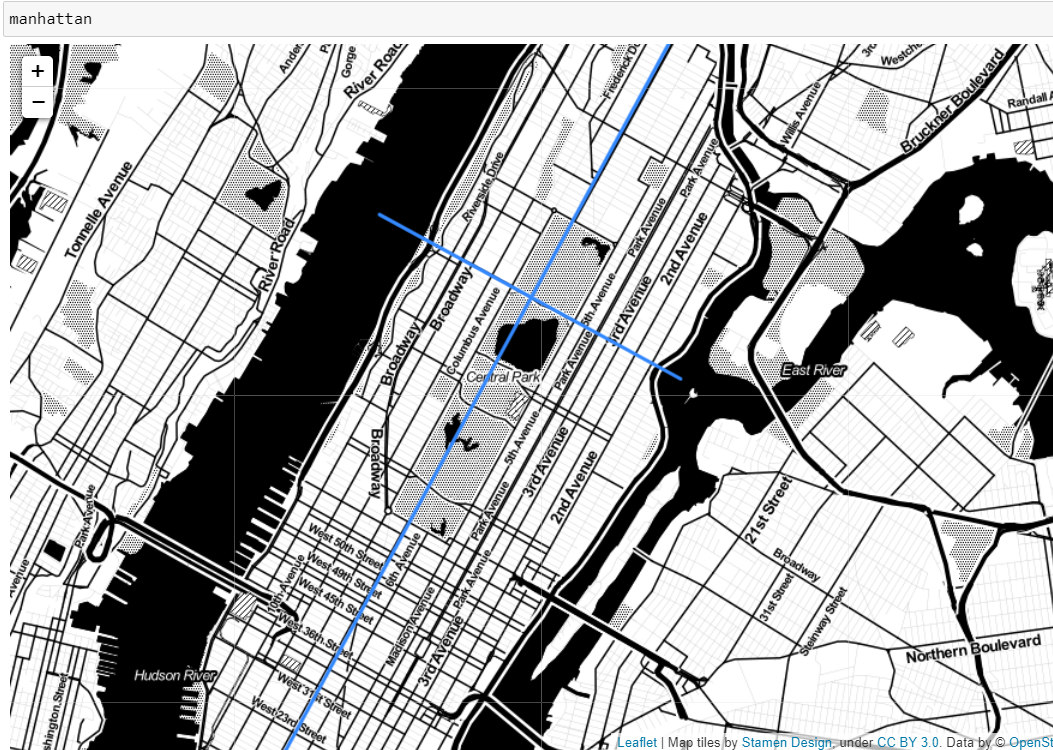

*Переведём координаты по следующим формулам:*
$$x_{new} = x \cos{a} + y \sin{a}$$
$$y_{new} = -x \sin{a} + y \cos{a}$$

, *где $a = \arctan(y_0 / x_0)$ - угол между новой осью и исходной ОХ, a ($x_0, y_0$) - новая ось в координатах исходной системы*

In [116]:
new_axis_vector = (y_axis[0][1] - y_axis[1][1], y_axis[0][0] - y_axis[1][0])    # vector for new axis
new_deg = np.arctan(new_axis_vector[1]/new_axis_vector[0])

In [117]:
def new_x(x, y, deg):
    return x * np.cos(deg) + y * np.sin(deg)

def new_y(x, y, deg):
    return -x * np.sin(deg) + y * np.cos(deg)

*Нарисуем некоторые переведённые координаты и убедимся, что дороги теперь параллельны новой оси:*

In [118]:
some_df = pd.DataFrame()
some_df['pickup_latitude'] = new_y(X_train.pickup_longitude, X_train.pickup_latitude, new_deg)
some_df['pickup_longitude'] = new_x(X_train.pickup_longitude, X_train.pickup_latitude, new_deg)

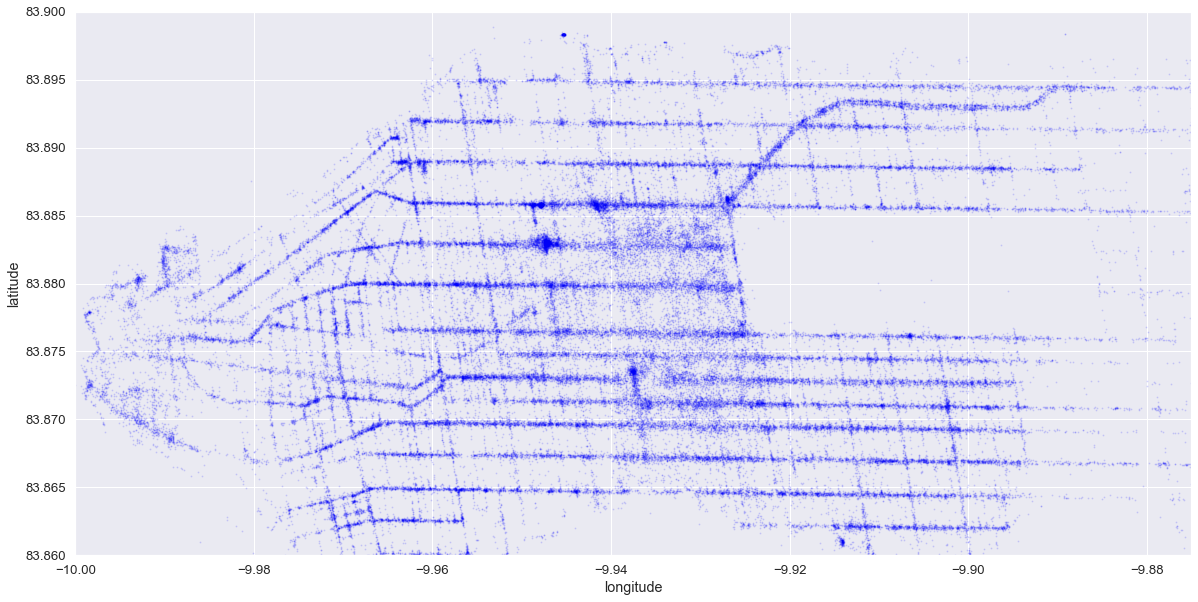

In [121]:
### from seminar 2
N = 100000
city_long_border = (-10, -9.875)
city_lat_border = (83.86, 83.9)

plt.figure(figsize=(20,10))
plt.scatter(some_df['pickup_longitude'].values[:N], some_df['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [122]:
def manhattan_distance(lat1, lng1, lat2, lng2):
    lng1 = new_x(lng1, lat1, new_deg)    # find new coordinates
    lng2 = new_x(lng2, lat2, new_deg)
    lat1 = new_y(lng1, lat1, new_deg)
    lat2 = new_y(lng2, lat2, new_deg)
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [123]:
X_train_16 = X_train_14_2.copy(deep=True)
X_train_16.loc[:, 'manhattan_distance'] = manhattan_distance(X_train_16['pickup_latitude'].values, 
                                                             X_train_16['pickup_longitude'].values, 
                                                             X_train_16['dropoff_latitude'].values, 
                                                             X_train_16['dropoff_longitude'].values)

X_train_16.loc[:, 'log_manhattan'] = np.log1p(X_train_16.manhattan_distance)

In [124]:
X_test_16 = X_test_13.copy(deep=True)
X_test_16.loc[:, 'manhattan_distance'] = manhattan_distance(X_test_16['pickup_latitude'].values, 
                                                            X_test_16['pickup_longitude'].values, 
                                                            X_test_16['dropoff_latitude'].values, 
                                                            X_test_16['dropoff_longitude'].values)

X_test_16.loc[:, 'log_manhattan'] = np.log1p(X_test_16.manhattan_distance)

In [125]:
log_hav_corr_train = X_train_16[['log_haversine']].corrwith(y_train_14)
log_man_corr_train = X_train_16[['log_manhattan']].corrwith(y_train_14)
print('Correlation with log of trip duration:')
print('log of manhattan: %.4f' % log_man_corr_train[0], '\tlog of haversine: %.4f' %log_hav_corr_train[0])

Correlation with log of trip duration:
log of manhattan: 0.7142 	log of haversine: 0.7766


Для `log_haversine` корреляция больше.

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [126]:
categorical_ft_16 = categorical_ft_13
numerical_ft_16 = numerical_ft_13 + ['log_manhattan']

In [127]:
X_train_16.drop(columns=['manhattan_distance'], inplace=True)
X_test_16.drop(columns=['manhattan_distance'], inplace=True)

In [128]:
mg_ohe = Pipeline(steps=[
    ('mapgrid', MapGridTransformer(best_params[0], best_params[1])),
    ('cell_group', CategoryGrouper(0.001)),
    ('route', RoutePairTransformer(100)),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

column_transformer_16 = ColumnTransformer([
    ('mapgrid', mg_ohe, grid_ft),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ft_16),
    ('scaling', StandardScaler(), numerical_ft_16)
])

ridge_pipeline = Pipeline(steps=[
    ('mg_ohe_sclr', column_transformer_16),
    ('regression', Ridge(best_ridge_alpha))
])

model_16 = ridge_pipeline.fit(X_train_16, y_train)
y_train_pred_16 = model_16.predict(X_train_16)
y_pred_16 = model_16.predict(X_test_16)

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred_16, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred_16, squared=True))

Test MSE = 0.2276
Train MSE = 0.1785


*Ошибка уменьшилась на 0.001, как можно увидеть, признак оказался полезным.*

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

<img src = "https://media.giphy.com/media/3o7TKRwpns23QMNNiE/giphy.gif" width="400">